### Libraries

In [47]:
#model.py 
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random 
import math
import numpy as np
from math import hypot

from mesa.time import RandomActivation

#server.py
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.ModularVisualization import VisualizationElement
from collections import defaultdict

#data visualization 
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import time 
from mesa.batchrunner import BatchRunner

sns.set_context("paper", rc={"font.size":15,"axes.titlesize":20,
                             "axes.labelsize":20,'xtick.labelsize': 15, 
                             'ytick.labelsize': 15, 'legend.fontsize': 15})

### Auxiliary Functions for Data Collector in Model.py

In [2]:
def pctDistance(incomegrp, pct):
    """
    calculate a list of percentages of the density of a given income group over total density 
    from city center to periphery;
    """
    def compute2(model):
        
        center = int(model.width/2)
        pctlst = []
        totalsubgrp = [0.000001] # in case that total subgrp is 0
        
        for r in range(center):
            counter = 0 
            left = int(center-(r+1))
            right = int(center+(r+1))
            
            #loop through bottom and top side of the ring grid
            for j in range(left, right):
                counter += model.patchgrid[j][left][incomegrp]
                counter += model.patchgrid[j][right-1][incomegrp]
                model.patchgrid[j][left]["distCBD"] = r
                model.patchgrid[j][right-1]["distCBD"] = r
                
            #loop through the left and right side of the ring grid
            for k in range(left+1, right-1):
                counter += model.patchgrid[left][k][incomegrp]
                counter += model.patchgrid[right-1][k][incomegrp]
                model.patchgrid[left][k]["distCBD"] = r
                model.patchgrid[right-1][k]["distCBD"] = r
                
            totalsubgrp.append(counter)
        
        if pct:
            total = sum(totalsubgrp)
            #[1:] is to get rid of the default 0.000001
            pctlst = [x / total for x in totalsubgrp][1:] 
            return pctlst 
        else:
            return totalsubgrp[1:] 
    
    return compute2

def initPatchDict():
    """
    initialize patch dictionary
    """
    return {
        "Npoor": 0,
        "Nmid": 0,
        "Nrich": 0,
        "density": 0,
        "Lprice": 0,
        "Hprice": 0,
        "jobs_prob": 0, 
        "distCBD": 0,
        "responsive_constant": 0
    }

def updatePatchDict(model):
    """
    for each step, it updates the items in patch dictionary
    """
    for agent, x, y in model.grid.coord_iter():
        patch = model.patchgrid[x][y]
        patch["responsive_constant"] = model.constant 
        agentsonpatch = model.grid.grid[x][y]
        
        patch["density"] = len(agentsonpatch)
        patch["Npoor"] = len([agent for agent in agentsonpatch if agent.income == 1])
        patch["Nmid"] = len([agent for agent in agentsonpatch if agent.income == 2])
        patch["Nrich"] = len([agent for agent in agentsonpatch if agent.income == 3])


        if patch["density"] == 0:
            patch["Hprice"] = 0
        else:
            #sum of income servers as a weighting difference for different income population
            #so that the same price can either accomodate a few rich or a lot of poor.
            if patch["responsive_constant"] == 0:
                patch["Hprice"] = 0
            else:
                patch["Hprice"] = patch["Lprice"] * (sum([agent.income for agent in agentsonpatch])/ patch["responsive_constant"])
        

### Model.py

Model.py defines the model and the model methods that will be used to: 
- initialize the model
- create the agents and assign values 
- create patch dictionary and assign values
- define data collectors 
- define the step function 

In [3]:
#model.py 

class ResidentialModel(Model):
    """
    Model
    """
    def __init__(self, width, height, N, constant, job_dist, land_dist, people_types_ratios): 
        #super().__init__(seed)
        self.width = width
        self.height = height
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True #default system parameter 
        self.patchgrid = dict.fromkeys(range(0, self.width), {})
        self.constant = constant 
        self.job_dist = job_dist
        self.land_dist = land_dist
        self.people_types_ratios = people_types_ratios
        
        for i in range(self.width):
            self.patchgrid[i] = dict.fromkeys(range(0, self.width), {})
            
        self.createIncomeGrp()
        self.createPatchDict()
        self.dataCollectorDefined()
       
    def createIncomeGrp(self): 
        
        # Add the agent to a random grid cell
        
        id = 0
        Num = self.num_agents
        people_ratios = self.people_types_ratios

        def createPeople(peopletype): 
            nonlocal id
            id += 1
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            a = PeopleAgent(id, peopletype, (x, y), self)
            self.schedule.add(a)
            self.grid.place_agent(a, (x, y))

        # Create People Agents
        
        ratios_sum = sum(people_ratios)
        ratios_num = list(map(lambda r: Num*r//ratios_sum, people_ratios))
        ratios_num[0] += Num - sum(ratios_num)
        
        for i, num in enumerate(ratios_num):
            for _ in range(num):
                createPeople(["poor", "middle", "rich"][i])
        
    def createPatchDict(self):
        # Creat patches as dictionaries 
            
        center = int(self.width/2)

        for r in range(center):

            left = int(center-(r+1))
            right = int(center+(r+1))

            #loop through bottom and top side of the ring grid
            for j in range(left, right):

                #init PatchDict 
                self.patchgrid[j][left] = initPatchDict()
                self.patchgrid[j][right-1] = initPatchDict()

                #assign distCBD
                self.patchgrid[j][left]["distCBD"] = r
                self.patchgrid[j][right-1]["distCBD"] = r

                #assign land price 
                self.patchgrid[j][left]["Lprice"] = int(np.random.choice(3, 1, p=self.land_dist[r])) + 1 
                self.patchgrid[j][right-1]["Lprice"] = int(np.random.choice(3, 1, p=self.land_dist[r])) + 1 

                #assign job probability 
                mean, var = self.job_dist[r]
                self.patchgrid[j][left]["jobs_prob"] = random.normalvariate(mean, var) 
                self.patchgrid[j][right-1]["jobs_prob"] = random.normalvariate(mean, var) 


            #loop through the left and right side of the ring grid
            for k in range(left+1, right-1):

                #init PatchDict 
                self.patchgrid[left][k] = initPatchDict()
                self.patchgrid[right-1][k] = initPatchDict()

                #assign distCBD
                self.patchgrid[left][k]["distCBD"] = r
                self.patchgrid[right-1][k]["distCBD"] = r

                #assign land price 
                self.patchgrid[left][k]["Lprice"] = int(np.random.choice(3, 1, p=self.land_dist[r])) + 1 
                self.patchgrid[right-1][k]["Lprice"] = int(np.random.choice(3, 1, p=self.land_dist[r])) + 1

                #assign job probability 
                mean, var = self.job_dist[r]
                self.patchgrid[left][k]["jobs_prob"] = random.normalvariate(mean, var) 
                self.patchgrid[right-1][k]["jobs_prob"] = random.normalvariate(mean, var) 
        
        #update initial PatchDict with deensity ... 
        updatePatchDict(self)
                

    def dataCollectorDefined(self):

        self.datacollector = DataCollector(
            model_reporters={"PctDistancePoor": pctDistance("Npoor", True),
                             "PctDistanceMid": pctDistance("Nmid", True),
                             "PctDistanceRich": pctDistance("Nrich", True)
                            })
        
        self.computeNDistance = DataCollector(
            model_reporters={"NDistancePoor": pctDistance("Npoor", False),
                             "NDistanceMid": pctDistance("Nmid", False),
                             "NDistanceRich": pctDistance("Nrich", False)
                            })
        
        self.computePctDistance = DataCollector(
            model_reporters={"PctDistancePoor": pctDistance("Npoor", True),
                             "PctDistanceMid": pctDistance("Nmid", True),
                             "PctDistanceRich": pctDistance("Nrich", True)
                            })

    
    def step(self):
        self.schedule.step()
        
        #density should be computed after all agents are moved. 
        updatePatchDict(self)
        
        #data collection 
        self.computePctDistance.collect(self)
        self.computeNDistance.collect(self)
        self.datacollector.collect(self)

### Agents.py

Agents.py defines how the agent (human) is created and the methods attached to it.

In [4]:
#agents.py 

class PeopleAgent(Agent):
    """
    Define PeopleAgent 
    """
    def __init__(self, unique_id, category, pos, model):
        super().__init__(unique_id, model)
        self.category = category
        self.model = model
        self.happy = False
        self.overdue = 0
        self.pos = pos
        
        average_dens = self.model.num_agents/(self.model.width*self.model.height)
        if category == "poor": 
            self.income = 1
        elif category == "middle":
            self.income = 2 
        elif category == "rich": 
            self.income = 3
        else: 
            raise Exception("category not found") 
    
    # for each step of one agent, find possible neighbors within certain radius
    def move(self):
        
        if self.income == 1:
            radius = 1
        elif self.income == 2:
            radius = 3
        else: 
            radius = 5
        
        possible_neighbors = self.model.grid.get_neighborhood(
            self.pos,
            True,
            radius = radius,
            include_center=False)
        
        new_position = False
        
        while possible_neighbors:
            neighbor = random.choice(possible_neighbors)
            possible_neighbors.remove(neighbor)
            patch = self.model.patchgrid[neighbor[0]][neighbor[1]]
            
            #compare with projected housing price and job probability
            if patch["responsive_constant"] == 0:
                projected_Hprice = 0
            else:
                projected_Hprice = patch["Lprice"] * ((sum([agent.income for agent in self.model.grid.grid[neighbor[0]][neighbor[1]]]) + self.income) / patch["responsive_constant"])
            if self.income >= projected_Hprice and random.random() <= patch["jobs_prob"]:
                new_position = neighbor
                break
                
        if new_position:
            self.model.grid.move_agent(self, new_position)
            self.pos = new_position 
            self.overdue = 0
        else:
            self.overdue += 1
            self.model.schedule.remove(self)
            if self.overdue >= 3:
                self.model.schedule.remove(self)
                
    #update agent happiness
    def updatehappiness(self):
        patch = self.model.patchgrid[self.pos[0]][self.pos[1]]
        self.happy = self.income >= patch["Hprice"] and random.random() <= patch["jobs_prob"] 
        
    def step(self):
        # check if income still higher than Lprice and job maintains
        self.updatehappiness()
        if not self.happy: 
            self.move()
        pass

### Test run

In [5]:
#default parapemter values 
num_agents = 90 
width = 10
height = 10 
constant = 15 

#first entry is mean and the second entry is variance 
default_job_dist = [
        (1, 0.1),
        (0.9, 0.1),
        (0.7, 0.1),
        (0.5, 0.1),
        (0.3, 0.1)
        ]

#sample 1, 2, 3 with the following probability 
default_land_dist = [
        (0, 0.2, 0.8),
        (0, 0.4, 0.6),
        (0.2, 0.3, 0.5),
        (0.6, 0.2, 0.2),
        (0.8, 0.2, 0)
    ]

test_ratio = [3, 5, 1]

test = ResidentialModel(width,height,num_agents,constant=constant,
        job_dist = default_job_dist,
        land_dist = default_land_dist,
        people_types_ratios = test_ratio)

In [6]:
for i in range(2):
    test.step()

### Server.py

Server.py defines how the model is presented in the interface browser.

In [7]:
#server.py

#overwrite the original CanvasGrid Class from Mesa so that it also portrays patch (though not being agents)
class CanvasGrid2(CanvasGrid):
    
    #overwriting the render function 
    def render(self, model):
        grid_state = defaultdict(list)
        for x in range(model.grid.width):
            for y in range(model.grid.height):
                cell_objects = model.grid.get_cell_list_contents([(x, y)]) + [model.patchgrid[x][y]]
                for obj in cell_objects:
                    portrayal = self.portrayal_method(obj)
                    if portrayal:
                        portrayal["x"] = x
                        portrayal["y"] = y
                        grid_state[portrayal["Layer"]].append(portrayal)

        return grid_state

#define the layout of canvases, agents, and patches
def layout(layout_choice):
    def agent_portrayal(agent):
        if type(agent) is dict:
            portrayal = {"Shape": "rect",
                         "Filled": True,
                         "Layer": 0,
                         "w": 1,
                         "h": 1,
                         "Color": "white",
                        }
            if layout_choice == "land_price":
                if agent["Lprice"] == 3: 
                    portrayal["Color"] = "LightGrey"
                elif agent["Lprice"] == 2:
                    portrayal["Color"] = "Grey"
                else: 
                    portrayal["Color"] = "black"

            elif layout_choice == "job_prob":
                portrayal["Color"] = "hsl(0, 0%, "+str(agent["jobs_prob"] * 100)+"%)"

            #density layout changes to numbers
            #density color is from 10 ~ 100%, assuming maximum density is 10. 
            elif layout_choice == "density":
                portrayal["Color"] = "hsl(0, 0%, "+str(agent["density"] * 10)+"%)"
                portrayal["text"] = agent["density"]
                portrayal["text_color"] = "teal"
            
            elif layout_choice == "percentage":
                if agent["density"] == 0:
                    portrayal["Color"] = "black"
                else: 
                    portrayal["Color"] = ["red"] * int(agent["Npoor"]/agent["density"] * 100)  + ["yellow"] * int(agent["Nmid"]/agent["density"] * 100)  + ["green"] * int(agent["Nrich"]/agent["density"] * 100)
            else: raise Exception("Patch Layer not found") 


        elif type(agent) is PeopleAgent: 
            portrayal = {"Shape": "circle",
                         "Filled": True,
                         "Layer": 1,
                         "r": 0.5}
            
            if layout_choice == "density":
                portrayal = {"Shape": "rect",
                             "Filled": True,
                             "Layer": 1,
                             "Color": "transparent",
                             "w": 1,
                             "h": 1
                            }
            
            elif layout_choice == "percentage":
                portrayal = {"Shape": "rect",
                             "Filled": True,
                             "Layer": 1,
                             "Color": "transparent",
                             "w": 1,
                             "h": 1
                             }
            else:     
                if agent.category == 'poor':
                    portrayal["Color"] = "red"
                elif agent.category == 'middle':
                    portrayal["Color"] = "yellow"
                    portrayal["Layer"] = 2
                    portrayal["r"] = 0.4
                else: 
                    portrayal["Color"] = "green"
                    portrayal["Layer"] = 3
                    portrayal["r"] = 0.3

        else: raise Exception("Agent Portrayal not found") 

        return portrayal
    return agent_portrayal

#suggest width and height to be multiple of 10 
width = 10
height = 10 
dimension = 260

#create four canvases
land_price = CanvasGrid2(layout("land_price"), width, height, dimension, dimension)
job_prob = CanvasGrid2(layout("job_prob"), width, height, dimension, dimension)
density = CanvasGrid2(layout("density"), width, height, dimension, dimension)
percentage = CanvasGrid2(layout("percentage"), width, height, dimension, dimension)

#define widgets that users can play with 
n_slider = UserSettableParameter("slider", "Number of Agents", 90, 90, 900, 9)

userparameters = {"width": width, "height": height, "N": n_slider, 
                  "constant": constant, "job_dist": default_job_dist, "land_dist": default_land_dist}

#personalized web layout in Javascript  
class Reorganize(VisualizationElement):
    def __init__(self):
        self.js_code = """
        canvasbox = document.querySelector('#elements')
        canvasbox.style.width = '1150px';
        allcanvas = document.querySelectorAll('canvas:not(.chartjs-render-monitor)');
        
        var namelist = ["Land Price", "Job Probability", "Density", "Percentage"]
        allcanvas.forEach(
            function (elem, index) {
            var div = document.createElement('div');
            div.style.display = 'inline-block';
            div.style.marginRight = '20px'; 
            div.style.marginBottom = '20px'; 
            div.style.marginTop = '20px';
            div.style.width = '260px';
            canvasbox.insertBefore(div, elem);
            div.appendChild(elem);
            div.appendChild(document.createTextNode(namelist[index]))
            }
        )
        """

JScode = Reorganize()

server = ModularServer(ResidentialModel,
                       [
                           land_price,
                           job_prob,
                           density,
                           percentage,
                           JScode
                       ],
                       "Residential Model",
                       userparameters)

In [8]:
server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"get_params"}
{"type":"reset"}


### Analysis.py

Analysis.py runs all the data analysis and visualizations. 

#### Default Parameters for Visualization

In [50]:
#visualization parameters
runs = 100
timesteps = 100
length = 5

#model parameter 
num_agents = 90 
width = 10
height = 10 
constant = 15 

job_dist = [
    (1.15, 0.1),
    (0.9, 0.1),
    (0.7, 0.1),
    (0.5, 0.1),
    (0.3, 0.1)
]

land_dist = [
    (0, 0.2, 0.8),
    (0, 0.5, 0.5),
    (0.2, 0.3, 0.5),
    (0.4, 0.3, 0.3),
    (0.6, 0.4, 0)
]

ratio = [5, 3, 1]

poorColor='Firebrick'
midColor='gold'
richColor='forestgreen'

#### Auxiliary Functions for Visualizations

In [8]:
def PctDistanceData(data, lst11, lst12, lst21, lst22, lst31, lst32):   
    """
    For one simulation, extract the median values of pct at each distance over 100 steps;
    Return six lists, corresponding to the distances and the median pct from each income groups
    """
    for i in range(length): 
        lst11.append(np.median([entry[i] for entry in data["PctDistancePoor"]]))
        lst12.append(i)
        lst21.append(np.median([entry[i] for entry in data["PctDistanceMid"]]))
        lst22.append(i)
        lst31.append(np.median([entry[i] for entry in data["PctDistanceRich"]]))
        lst32.append(i)

In [9]:
def plotPctDistance(data, population, color):
    """
    plot the line graph given data and target income group name and color strings
    """
    plot = sns.boxplot(x='distance', y='pct', data=data, width=0.3, color=color, boxprops=dict(alpha=.7))
    plot.set_title('Median Percentages of ' + str(population) + ' Population against Distance to CBD')
    plot.set_xlabel('Unit of Distance away from CBD')
    plot.set_ylabel('Percentage of ' + str(population) + ' Population')
    sns.lineplot(x='distance', y='pct', data=data, ci=None)

In [10]:
def initDistribution(Xvar1, Yvar2, iterations):
    """
    generate data for Figure 3 and 4, creating two lists of values of two variables of choice at all patches 
    when the model is initialized. 
    """
    #100 initialization 
    initVar1 = []
    initVar2 = []

    for i in range(iterations):
        test = ResidentialModel(width,height,num_agents,constant=constant,
            job_dist = default_job_dist,
            land_dist = default_land_dist,
            people_types_ratios = ratio)

        for x in range(test.width):
            for y in range(test.height):
                initVar1.append(test.patchgrid[x][y][Xvar1])
                initVar2.append(test.patchgrid[x][y][Yvar2])
    return initVar1, initVar2

In [11]:
def generateLineChartpd(input_data, swipeby, iterator):
    
    """
    given the input data from the batch run, the function automatically step through the parameter values, 
    and generate the data frame for the LINE CHART metric. 
    """
    
    poorpctruns = pd.DataFrame()
    midpctruns = pd.DataFrame()
    richpctruns = pd.DataFrame()

    poorpctlst = []
    poordistance = []
    midpctlst = []
    middistance = []
    richpctlst = []
    richdistance = []


    filtered = input_data.loc[input_data[swipeby] == iterator].DataCollector
    for run in filtered:
        data = run.get_model_vars_dataframe()
        PctDistanceData(data, poorpctlst, poordistance, midpctlst, middistance, richpctlst, richdistance)

    poorpctruns['distance'] = poordistance
    poorpctruns['pct'] = poorpctlst
    midpctruns['distance'] = middistance
    midpctruns['pct'] = midpctlst
    richpctruns['distance'] = richdistance
    richpctruns['pct'] = richpctlst
    
    return poorpctruns, midpctruns, richpctruns

In [12]:
def generateBarChartpd(input_data, swipeby, iterator, patchN):
    """
    given the input data from the batch run, the function automatically step through the parameter values, 
    and generate the data frame for the BAR CHART metric. 
    """
    poorNlst = [[] for i in range(5)]
    midNlst = [[] for i in range(5)]
    richNlst = [[] for i in range(5)]
    
    barchartpd = pd.DataFrame()
    
    filtered = input_data.loc[input_data[swipeby] == iterator].computeNDistance
    for run in filtered:
        #retrieve data and organize them into new dictionaries
        pctdistance_df = run.get_model_vars_dataframe()
               
        #for one simulation 
        for i in range(5):
           
            #for plotting N of income group over distance, calculate median of 100 steps at each distance
            poorNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistancePoor"]])/patchN[i], 2))
            midNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceMid"]])/patchN[i], 2))
            richNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceRich"]])/patchN[i], 2))
        
    barchartpd["poor"] = [np.median(i) for i in poorNlst]
    barchartpd["mid"] = [np.median(i) for i in midNlst]
    barchartpd["rich"] = [np.median(i) for i in richNlst]
    
    return barchartpd

### Exploring Metric #1: Median percentage of people within their own income group versus distance

In [346]:
poorpctruns = pd.DataFrame()
midpctruns = pd.DataFrame()
richpctruns = pd.DataFrame()

poorpctlst = []
poordistance = []
midpctlst = []
middistance = []
richpctlst = []
richdistance = []

for run in range(runs):
    
    #model runs
    model = ResidentialModel(width,height,num_agents,constant,default_job_dist,default_land_dist,ratio)
    for t in range(timesteps):
        model.step()
    
    #keep adding data from each runs
    #retrieve data and organize them into new dictionaries
    data = model.computePctDistance.get_model_vars_dataframe()
    PctDistanceData(data, poorpctlst, poordistance, midpctlst, middistance, richpctlst, richdistance)
    
poorpctruns['distance'] = poordistance
poorpctruns['pct'] = poorpctlst
midpctruns['distance'] = middistance
midpctruns['pct'] = midpctlst
richpctruns['distance'] = richdistance
richpctruns['pct'] = richpctlst

#### Check the difference between mean and variance, and the distribution of data

(array([  3.,   1.,   4.,   4.,  20.,  36.,  17.,   6.,   6.,   3.]),
 array([ 0.1       ,  0.134     ,  0.168     ,  0.202     ,  0.236     ,
         0.26999999,  0.30399999,  0.33799999,  0.37199999,  0.40599999,
         0.43999999]),
 <a list of 10 Patch objects>)

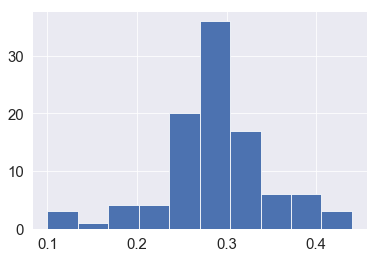

In [67]:
plt.hist([entry[1] for entry in data["PctDistancePoor"]])

In [68]:
for i in range(5):
    print('distance', i, 'mean', np.mean([entry[4] for entry in data["PctDistancePoor"]]))
    print('distance', i, 'median', np.median([entry[4] for entry in data["PctDistancePoor"]]))

distance 0 mean 0.137599997248
distance 0 median 0.1399999972
distance 1 mean 0.137599997248
distance 1 median 0.1399999972
distance 2 mean 0.137599997248
distance 2 median 0.1399999972
distance 3 mean 0.137599997248
distance 3 median 0.1399999972
distance 4 mean 0.137599997248
distance 4 median 0.1399999972


#### Checking the confidence intervals through box plots

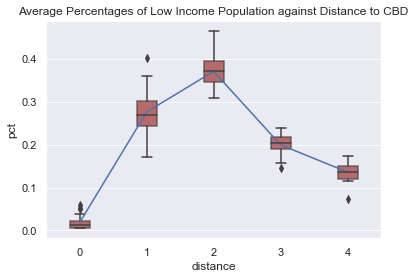

In [219]:
plotPctDistance(poorpctruns, "Low Income", "Firebrick")

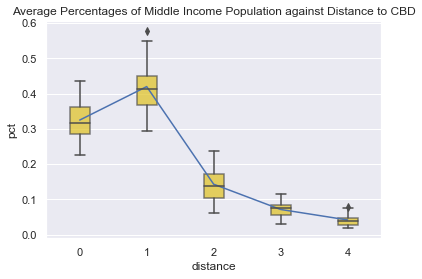

In [220]:
plotPctDistance(midpctruns, "Middle Income", "gold")

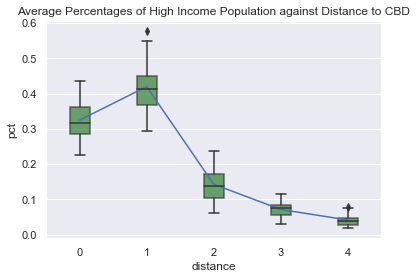

In [221]:
plotPctDistance(midpctruns, "High Income", "forestgreen")

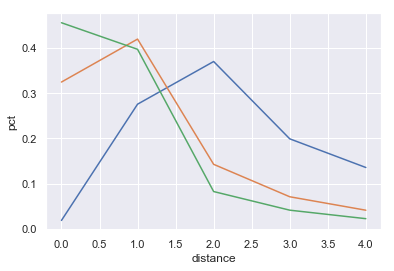

In [222]:
sns.lineplot(x='distance', y='pct', data=poorpctruns, ci=None)
sns.lineplot(x='distance', y='pct', data=midpctruns, ci=None)
sns.lineplot(x='distance', y='pct', data=richpctruns, ci=None)

### Exploring Metric #2: Median density per patch by income groups versus distance

In [269]:
poorNlst = [[] for i in range(5)]
midNlst = [[] for i in range(5)]
richNlst = [[] for i in range(5)]
barchartpd = pd.DataFrame()

runs = 10
steps = 100
n_agents = 90

for run in range(runs):
    
    #model runs
    model = ResidentialModel(n_agents, 10, 10, job_dist=job_dist, land_dist=land_dist)
    
    for t in range(steps):
        model.step()
    
    #retrieve data and organize them into new dictionaries
    pctdistance_df = model.computeNDistance.get_model_vars_dataframe()
    
    #for one simulation 
    for i in range(5):
        
        #for plotting N of income group over distance, calculate median of 100 steps at each distance
        poorNlst[i].append(np.median([entry[i] for entry in pctdistance_df["NDistancePoor"]]))
        midNlst[i].append(np.median([entry[i] for entry in pctdistance_df["NDistanceMid"]]))
        richNlst[i].append(np.median([entry[i] for entry in pctdistance_df["NDistanceRich"]]))
        

barchartpd["poor"] = [round(np.median(i)) for i in poorNlst]
barchartpd["mid"] = [round(np.median(i)) for i in midNlst]
barchartpd["rich"] = [round(np.median(i)) for i in richNlst]

barchartpd

,poor,mid,rich
0,0,10,4
1,14,12,4
2,16,4,0
3,9,2,0
4,9,1,0


Text(0,0.5,'Median number of Residents')

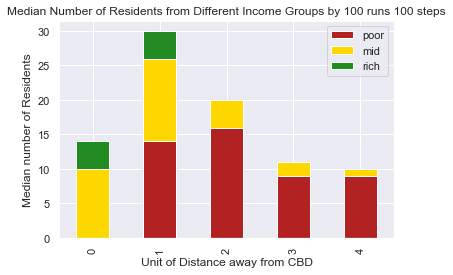

In [270]:
#this assume the model stablize quickly. 
sns.set()
barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, color=('Firebrick', 'gold','forestgreen'))
plt.title('Median Number of Residents from Different Income Groups by 100 runs 100 steps')
plt.xlabel('Unit of Distance away from CBD')
plt.ylabel('Median number of Residents')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

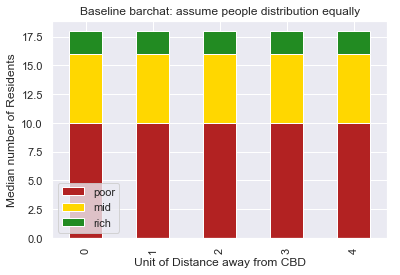

In [137]:
#baseline barchart: no meaning distribution
nullhypo = pd.DataFrame()
nullhypo["poor"] = [10, 10, 10, 10, 10]
nullhypo['mid'] = [6, 6, 6, 6, 6]
nullhypo['rich']= [2, 2, 2, 2, 2]

nullhypo[['poor','mid','rich']].plot(kind='bar', stacked=True, color=('Firebrick', 'gold','forestgreen'))
plt.title('Baseline barchat: assume people distribution equally')
plt.xlabel('Unit of Distance away from CBD')
plt.ylabel('Median number of Residents')
plt.xticks(rotation=90)

### Generate Figure 3 and 4. Line graph showing initialized distribution of land price and job probability 

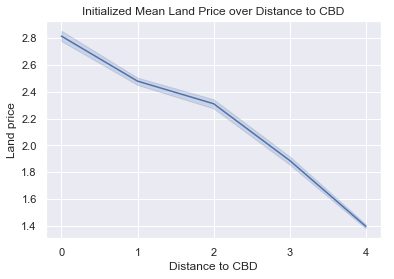

In [85]:
x, y = initDistribution('distCBD', 'Lprice', 100)

plot = sns.lineplot(x=x, y=y)
plot.set_title('Initialized Mean Land Price over Distance to CBD')
plot.set_xlabel('Distance to CBD')
plot.set_ylabel('Land price')
plot.set(xticks=np.arange(0,5,1))

plt.savefig('InitLprice.jpg', dpi=500)

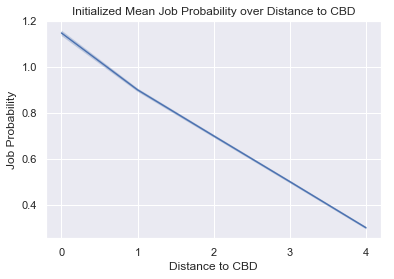

In [86]:
x, y = initDistribution('distCBD', 'jobs_prob', 100)

plot = sns.lineplot(x=x, y=y)
plot.set_title('Initialized Mean Job Probability over Distance to CBD')
plot.set_xlabel('Distance to CBD')
plot.set_ylabel('Job Probability')
plot.set(xticks=np.arange(0,5,1))

plt.savefig('InitJobsProb.jpg', dpi=500)

### Generate Figure 7 and 8. Swipping through N

In [69]:
runs = 100

fixed_params = {"width": width,
                "height": height,
                "constant": constant,
                "job_dist": job_dist,
                "land_dist": land_dist,
                "people_types_ratios": ratio 
               }

variable_params = {"N": range(90, 810+1, 90)}

batch_run = BatchRunner(ResidentialModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=runs,
                        max_steps=100,
                        model_reporters={"DataCollector": lambda m: m.computePctDistance,"computeNDistance": lambda m: m.computeNDistance}
                       )
    
batch_run.run_all()

900it [18:04,  2.54s/it]


In [184]:
run_data = batch_run.get_model_vars_dataframe()
len(run_data.DataCollector)

900

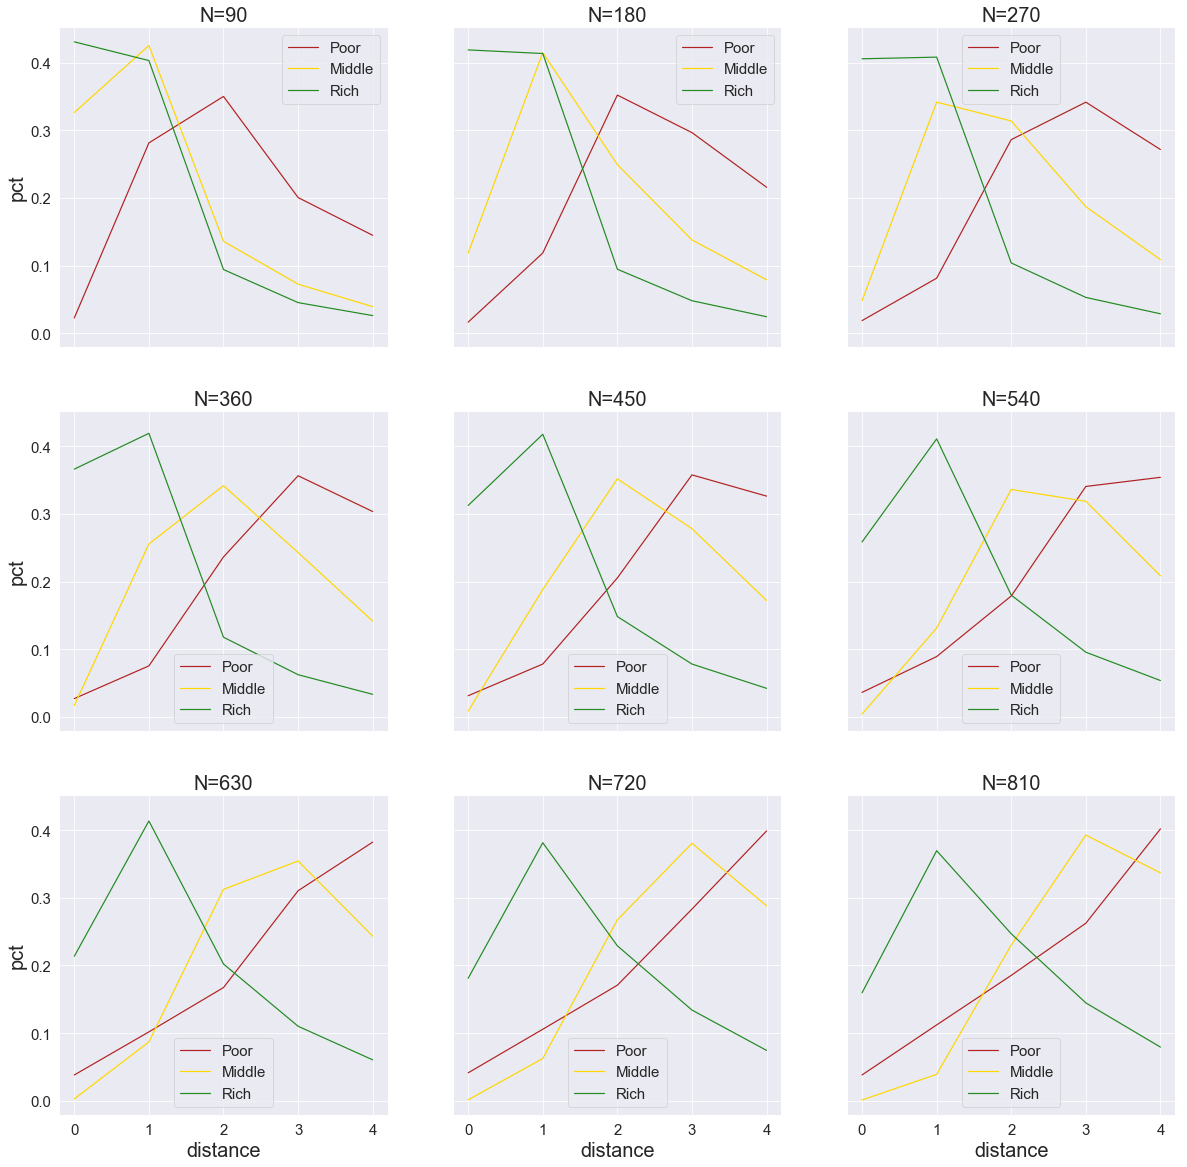

In [243]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, sharex=True, sharey=True, figsize=(20,20))

for N in range(90, 810+1, 90):

    poorpctruns, midpctruns, richpctruns = generateLineChartpd(run_data, "N", N)

    sns.lineplot(x='distance', y='pct', data=poorpctruns, ci=None, ax=axs[(N//90-1)//3, (N//90-1)%3], label="Poor", color=poorColor)
    sns.lineplot(x='distance', y='pct', data=midpctruns, ci=None, ax=axs[(N//90-1)//3, (N//90-1)%3], label="Middle", color=midColor)
    sns.lineplot(x='distance', y='pct', data=richpctruns, ci=None, ax=axs[(N//90-1)//3, (N//90-1)%3], label="Rich", color=richColor) \
       .set_title('N=%d' % N)

plt.savefig('AllPctByN.svg')
plt.savefig('AllPctByN.jpg')

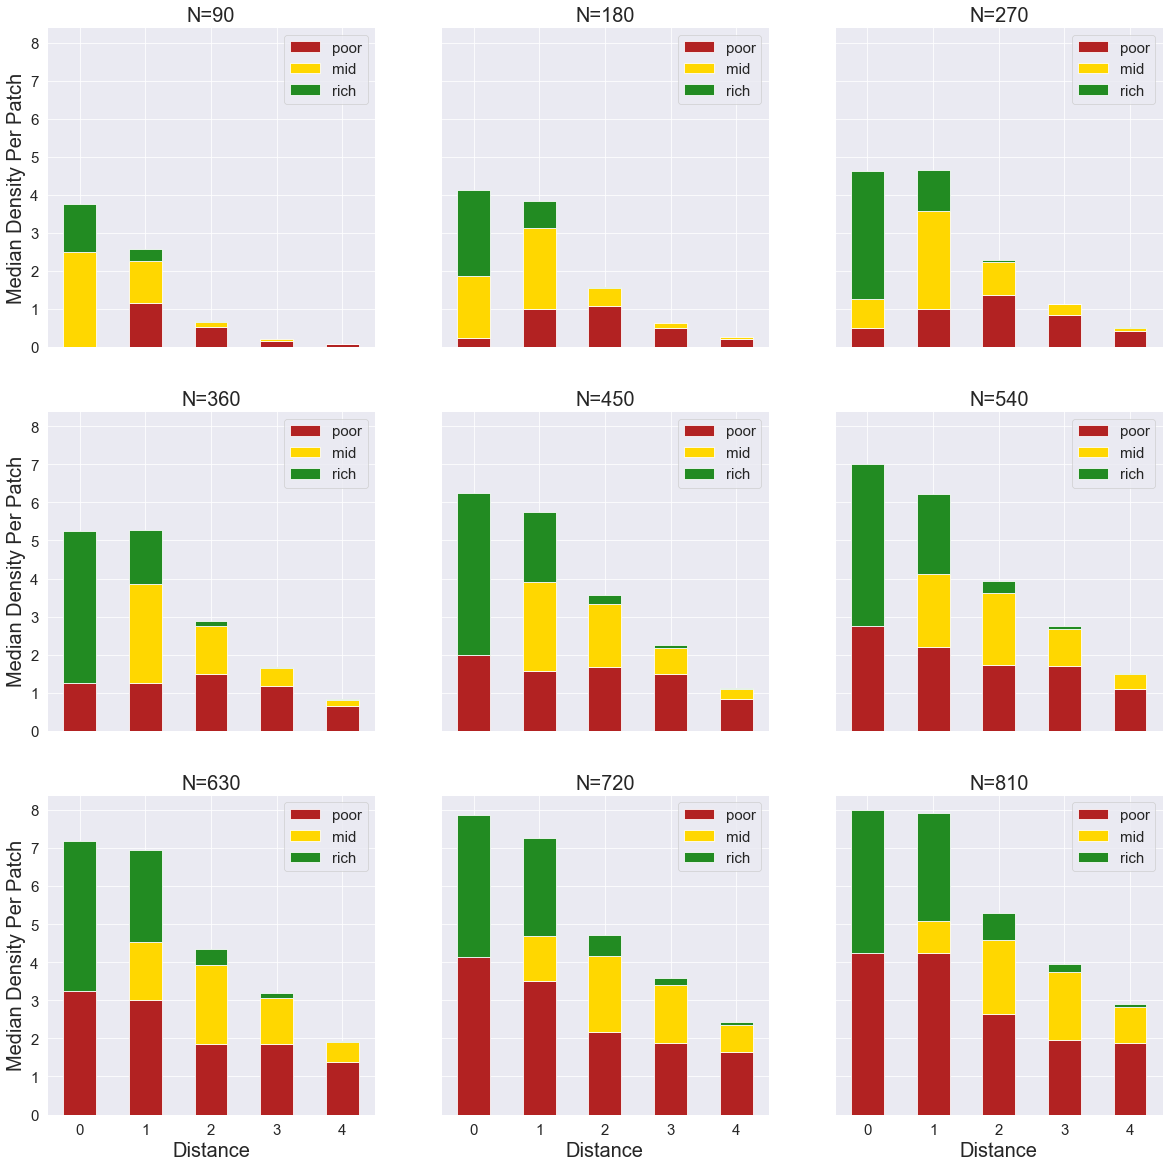

In [252]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, sharex=True, sharey=True, figsize=(20,20))
patchN = [4, 12, 32, 60, 96]

for N in range(90, 810+1, 90):
    
    barchartpd = generateBarChartpd(run_data, "N", N, patchN)
    
    barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, color=(poorColor, midColor, richColor), rot=0, ax=axs[(N//90-1)//3, (N//90-1)%3]) \
        .set_title('N=%d' % N)

#fig.suptitle('Median Number of Residents from Different Income Groups by 100 runs 100 steps')
for ax in axs.flat:
    ax.set(xlabel='Distance', ylabel='Median Density Per Patch')

plt.savefig('BarchartByN.svg')
plt.savefig('BarchartByN.jpg')

### Generate Figure 9 and 10. Swipping through K

In [160]:
from mesa.batchrunner import BatchRunner

runs = 100

fixed_params = {"width": width,
                "height": height,
                "N": 90,
                "job_dist": job_dist,
                "land_dist": land_dist
               }

variable_params = {"constant": range(0, 40+1, 5)}

batch_run2 = BatchRunner(ResidentialModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=runs,
                        max_steps=100,
                        model_reporters={"DataCollector": lambda m: m.computePctDistance,"computeNDistance": lambda m: m.computeNDistance}
                       )
    
batch_run2.run_all()

900it [03:16,  6.20it/s]


In [161]:
run_data2 = batch_run2.get_model_vars_dataframe()
len(run_data2)

900

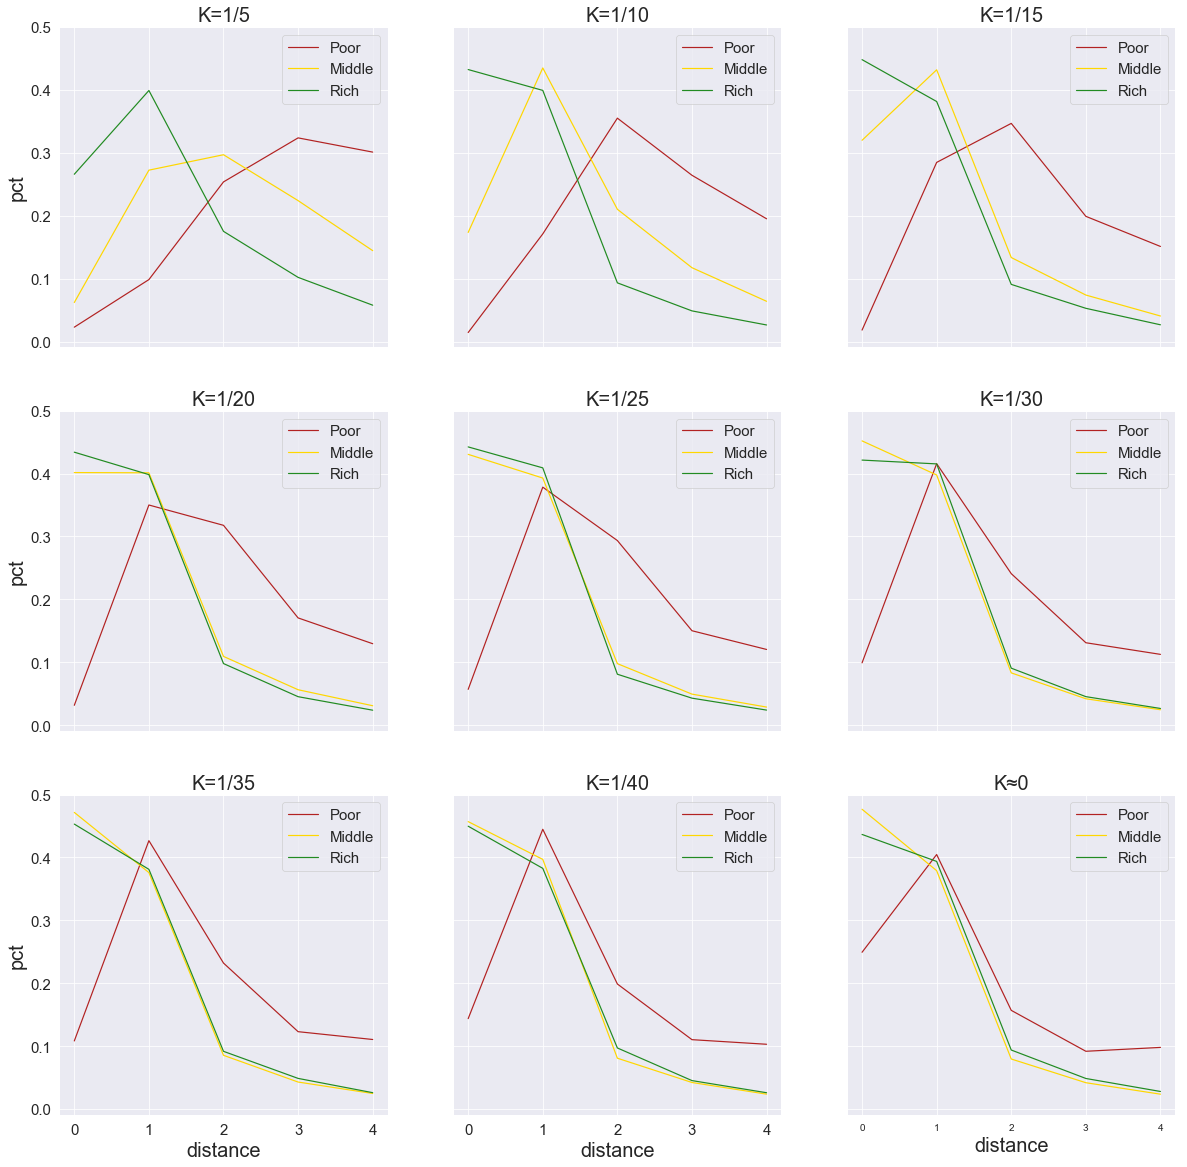

In [246]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, sharex=True, sharey=True, figsize=(20,20))

for K in range(0, 40+1, 5):
    
    poorpctruns, midpctruns, richpctruns = generateLineChartpd(run_data2, "constant", K)
    
    if K == 0:
        sns.lineplot(x='distance', y='pct', data=poorpctruns, ci=None, ax=axs[-1, -1%3], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns, ci=None, ax=axs[-1, -1%3], label="Middle", color=midColor).tick_params(labelsize=10)
        sns.lineplot(x='distance', y='pct', data=richpctruns, ci=None, ax=axs[-1, -1%3], label="Rich", color=richColor) \
           .set_title('K≈0')
    
    else:
        sns.lineplot(x='distance', y='pct', data=poorpctruns, ci=None, ax=axs[(K-5)//5//3, (K-5)//5%3], label="Poor", color=poorColor)
        sns.lineplot(x='distance', y='pct', data=midpctruns, ci=None, ax=axs[(K-5)//5//3, (K-5)//5%3], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns, ci=None, ax=axs[(K-5)//5//3, (K-5)//5%3], label="Rich", color=richColor) \
           .set_title('K=1/%d' % K) 
    
plt.savefig('AllPctByK.svg')
plt.savefig('AllPctByK.jpg')

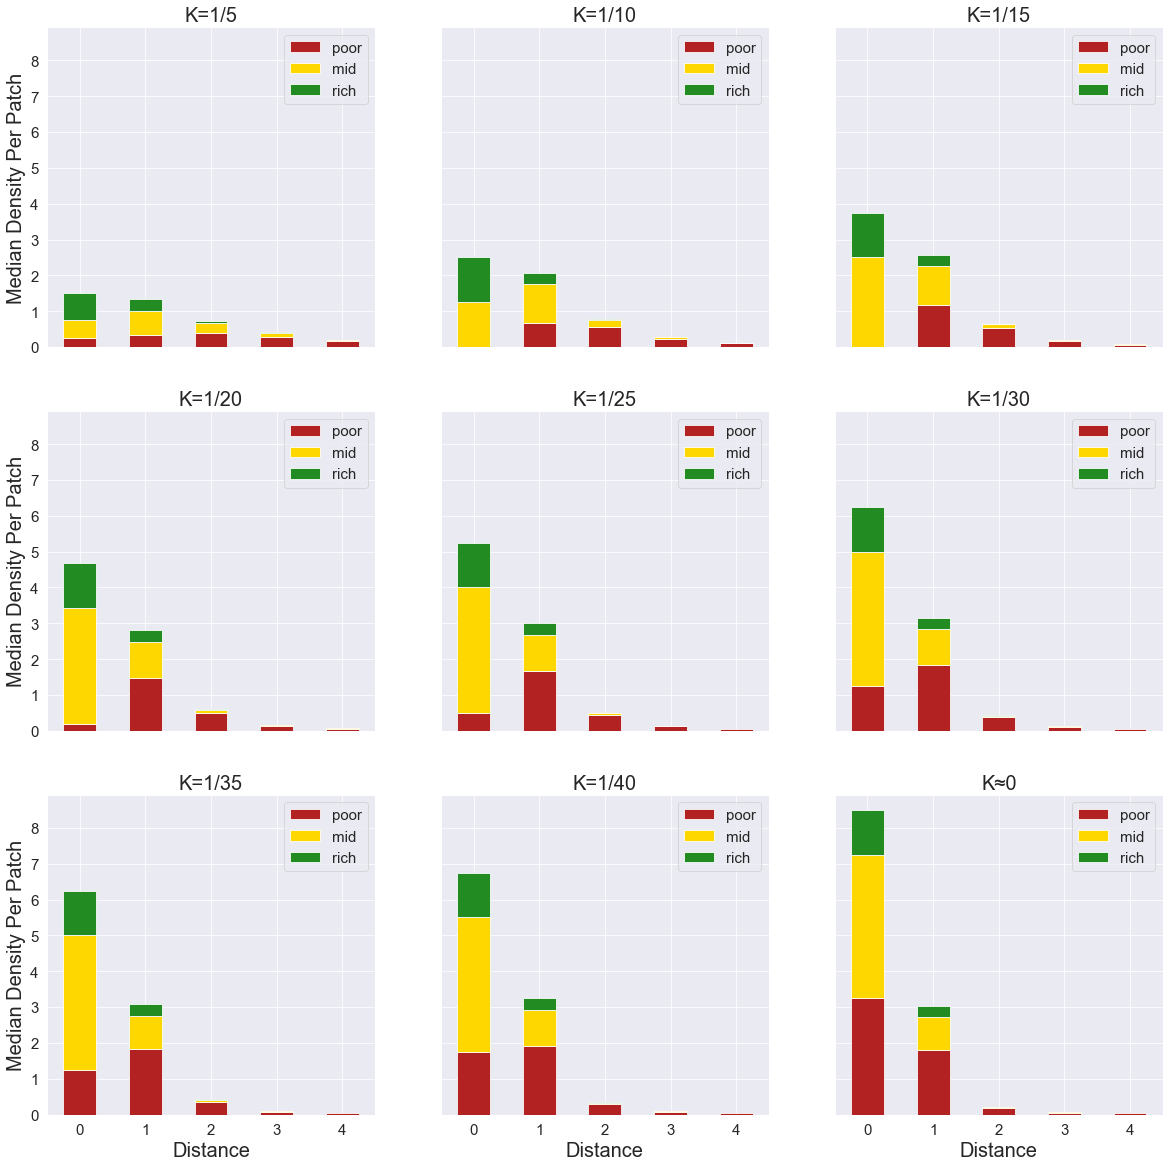

In [253]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, sharey=True, sharex=True, figsize=(20,20))
patchN = [4, 12, 32, 60, 96]

for K in range(0, 40+1, 5):
    
    barchartpd = generateBarChartpd(run_data2, "constant", K, patchN) 
    
    if K==0:
        barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, 
                                           color=(poorColor, midColor, richColor), 
                                           rot=0, ax=axs[-1, -1%3]) \
        .set_title('K≈%d' % K)
    else:
        barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, 
                                               color=(poorColor, midColor, richColor), 
                                               rot=0, ax=axs[(K-5)//5//3, (K-5)//5%3]) \
            .set_title('K=1/%d' % K)

#fig.suptitle('Median Number of Residents from Different Income Groups by 100 runs 100 steps')
for ax in axs.flat:
    ax.set(xlabel='Distance', ylabel='Median Density Per Patch')

plt.savefig('BarchartByK.svg')
plt.savefig('BarchartByK.jpg')

### Generate Figure 11 and 12. Swipping through Ratio

In [331]:
from mesa.batchrunner import BatchRunner

runs = 100

fixed_params = {"width": width,
                "height": height,
                "constant": constant,
                "N": num_agents,
                "job_dist": job_dist,
                "land_dist": land_dist
               }

#a mostly middle class city, a mostly rich city, an equal city, a mostly poor city
test_ratios = [(1, 7, 1), (7, 1, 1), (1, 1, 7), (1, 3, 5), (3, 3, 3), (5, 3, 1)]

variable_params = {"people_types_ratios": test_ratios}

batch_run3 = BatchRunner(ResidentialModel,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=runs,
                        max_steps=100,
                        model_reporters={"DataCollector": lambda m: m.computePctDistance,"computeNDistance": lambda m: m.computeNDistance}
                       )
    
batch_run3.run_all()

600it [03:18,  5.06it/s]


In [310]:
run_data3 = batch_run3.get_model_vars_dataframe()
len(run_data3)

400

In [327]:
run_data3.loc[run_data3.people_types_ratios==(7,1,1)].head()

,people_types_ratios,Run,DataCollector,computeNDistance,width,land_dist,height,job_dist,constant,N


#### For some reason the data for 7:1:1 and 1:1:7 is empty in BatchRunner even though it was one of the inputs. So I ran the data for 7:1:1 and 1:1:7 seperately. 

In [336]:
#get the data for 7:1:1 and 1:1:7 sepeartely 

poorpctruns_sub = pd.DataFrame()
midpctruns_sub = pd.DataFrame()
richpctruns_sub = pd.DataFrame()

poorpctlst = []
poordistance = []
midpctlst = []
middistance = []
richpctlst = []
richdistance = []

for run in range(100):
    
    #model runs
    model711 = ResidentialModel(width,height,num_agents,constant=constant,
        job_dist = job_dist,
        land_dist = land_dist,
        people_types_ratios = (7,1,1))
    for t in range(100):
        model711.step()
    
    #keep adding data from each runs
    #retrieve data and organize them into new dictionaries
    data = model711.computePctDistance.get_model_vars_dataframe()
    PctDistanceData(data, poorpctlst, poordistance, midpctlst, middistance, richpctlst, richdistance)
    
poorpctruns_sub['distance'] = poordistance
poorpctruns_sub['pct'] = poorpctlst
midpctruns_sub['distance'] = middistance
midpctruns_sub['pct'] = midpctlst
richpctruns_sub['distance'] = richdistance
richpctruns_sub['pct'] = richpctlst

In [338]:
poorpctruns_sub2 = pd.DataFrame()
midpctruns_sub2 = pd.DataFrame()
richpctruns_sub2 = pd.DataFrame()

poorpctlst = []
poordistance = []
midpctlst = []
middistance = []
richpctlst = []
richdistance = []

for run in range(100):
    
    #model runs
    model117 = ResidentialModel(width,height,num_agents,constant=constant,
        job_dist = job_dist,
        land_dist = land_dist,
        people_types_ratios = (1,1,7))
    for t in range(100):
        model117.step()
    
    #keep adding data from each runs
    #retrieve data and organize them into new dictionaries
    data = model117.computePctDistance.get_model_vars_dataframe()
    PctDistanceData(data, poorpctlst, poordistance, midpctlst, middistance, richpctlst, richdistance)
    
poorpctruns_sub2['distance'] = poordistance
poorpctruns_sub2['pct'] = poorpctlst
midpctruns_sub2['distance'] = middistance
midpctruns_sub2['pct'] = midpctlst
richpctruns_sub2['distance'] = richdistance
richpctruns_sub2['pct'] = richpctlst

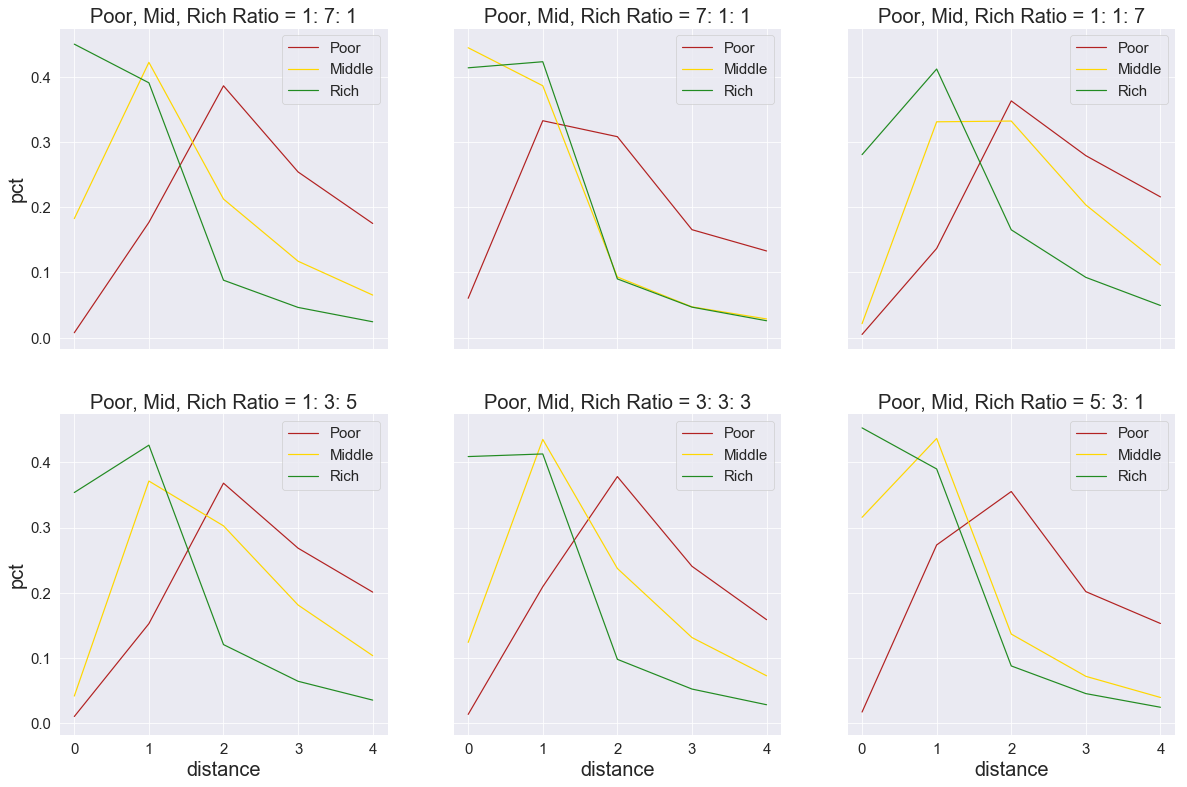

In [339]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex=True, sharey=True, figsize=(20,13))

position_ct = 0

for ratio in test_ratios:

    poorpctruns, midpctruns, richpctruns = generateLineChartpd(run_data3, "people_types_ratios", ratio)
    
    if ratio == (7,1,1):
        sns.lineplot(x='distance', y='pct', data=poorpctruns_sub, ci=None, ax=axs[0, 1], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns_sub, ci=None, ax=axs[0, 1], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns_sub, ci=None, ax=axs[0, 1], label="Rich", color=richColor) \
           .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
    
    elif ratio == (1,1,7):
        sns.lineplot(x='distance', y='pct', data=poorpctruns_sub2, ci=None, ax=axs[0, 2], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns_sub2, ci=None, ax=axs[0, 2], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns_sub2, ci=None, ax=axs[0, 2], label="Rich", color=richColor) \
           .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
        
    else:
        sns.lineplot(x='distance', y='pct', data=poorpctruns, ci=None, ax=axs[position_ct//3, position_ct%3], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns, ci=None, ax=axs[position_ct//3, position_ct%3], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns, ci=None, ax=axs[position_ct//3, position_ct%3], label="Rich", color=richColor) \
           .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
    
    position_ct += 1

plt.savefig('AllPctByRatio.jpg')

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharex=True, sharey=True, figsize=(20,13))

position_ct = 0

for ratio in test_ratios:

    poorpctruns, midpctruns, richpctruns = generateLineChartpd(run_data3, "people_types_ratios", ratio)
    
    if ratio == (7,1,1):
        sns.lineplot(x='distance', y='pct', data=poorpctruns_sub, ci=None, ax=axs[0, 1], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns_sub, ci=None, ax=axs[0, 1], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns_sub, ci=None, ax=axs[0, 1], label="Rich", color=richColor) \
           .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
    
    elif ratio == (1,1,7):
        sns.lineplot(x='distance', y='pct', data=poorpctruns_sub2, ci=None, ax=axs[0, 2], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns_sub2, ci=None, ax=axs[0, 2], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns_sub2, ci=None, ax=axs[0, 2], label="Rich", color=richColor) \
           .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
        
    else:
        sns.lineplot(x='distance', y='pct', data=poorpctruns, ci=None, ax=axs[position_ct//3, position_ct%3], label="Poor", color=poorColor).set(xticks=np.arange(0,5,1))
        sns.lineplot(x='distance', y='pct', data=midpctruns, ci=None, ax=axs[position_ct//3, position_ct%3], label="Middle", color=midColor)
        sns.lineplot(x='distance', y='pct', data=richpctruns, ci=None, ax=axs[position_ct//3, position_ct%3], label="Rich", color=richColor) \
           .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
    
    position_ct += 1

plt.savefig('AllPctByRatio.jpg')

#### Generate data for (1,1,7)

In [353]:
poorNlst = [[] for i in range(5)]
midNlst = [[] for i in range(5)]
richNlst = [[] for i in range(5)]

barchartpd_117 = pd.DataFrame()

for run in range(100):
    
    model_117 = ResidentialModel(width,height,num_agents,constant=constant,
        job_dist = job_dist,
        land_dist = land_dist,
        people_types_ratios = (1,1,7))
    for t in range(100):
        model_117.step()
    
    #retrieve data and organize them into new dictionaries
    pctdistance_df = model_117.computeNDistance.get_model_vars_dataframe()

    #for one simulation 
    for i in range(5):
        #for plotting N of income group over distance, calculate median of 100 steps at each distance
        poorNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistancePoor"]])/patchN[i], 2))
        midNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceMid"]])/patchN[i], 2))
        richNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceRich"]])/patchN[i], 2))

barchartpd_117["poor"] = [np.median(i) for i in poorNlst]
barchartpd_117["mid"] = [np.median(i) for i in midNlst]
barchartpd_117["rich"] = [np.median(i) for i in richNlst]

#### generate data for 1:1:7

In [354]:
poorNlst = [[] for i in range(5)]
midNlst = [[] for i in range(5)]
richNlst = [[] for i in range(5)]

barchartpd_711 = pd.DataFrame()

for run in range(100):
    
    model_711 = ResidentialModel(width,height,num_agents,constant=constant,
        job_dist = job_dist,
        land_dist = land_dist,
        people_types_ratios = (7,1,1))
    for t in range(100):
        model_711.step()
    
    #retrieve data and organize them into new dictionaries
    pctdistance_df = model_711.computeNDistance.get_model_vars_dataframe()

    #for one simulation 
    for i in range(5):
        #for plotting N of income group over distance, calculate median of 100 steps at each distance
        poorNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistancePoor"]])/patchN[i], 2))
        midNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceMid"]])/patchN[i], 2))
        richNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceRich"]])/patchN[i], 2))

barchartpd_711["poor"] = [np.median(i) for i in poorNlst]
barchartpd_711["mid"] = [np.median(i) for i in midNlst]
barchartpd_711["rich"] = [np.median(i) for i in richNlst]

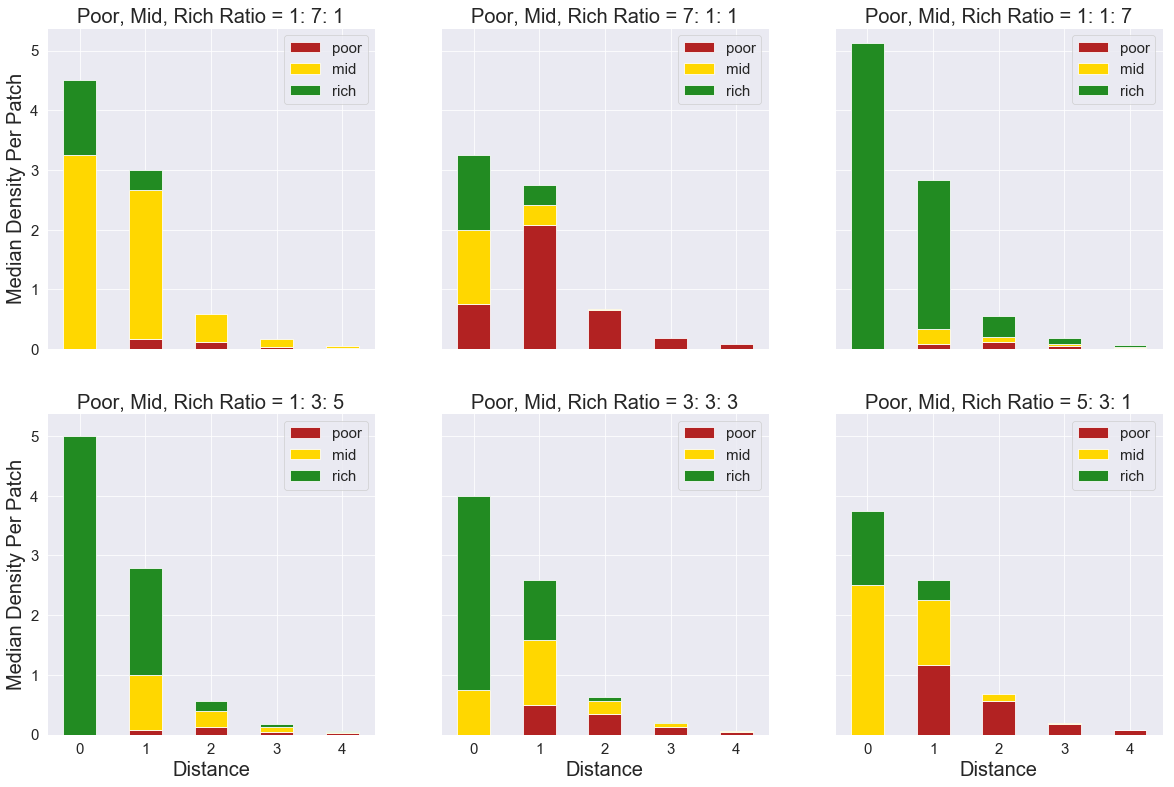

In [356]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharey=True, sharex=True, figsize=(20,13))
patchN = [4, 12, 32, 60, 96]
position_ct = 0

for ratio in test_ratios:
    
    if ratio == (1,1,7):
        barchartpd = barchartpd_117
        
        barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, 
                                           color=(poorColor, midColor, richColor), 
                                           rot=0, ax=axs[0, 2]) \
        .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
        
    elif ratio == (7,1,1):
        barchartpd = barchartpd_711
        
        barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, 
                                           color=(poorColor, midColor, richColor), 
                                           rot=0, ax=axs[0, 1]) \
        .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
        
    else:
        barchartpd = generateBarChartpd(run_data3, "people_types_ratios", ratio, patchN) 
    
        barchartpd[['poor','mid','rich']].plot(kind='bar', stacked=True, 
                                           color=(poorColor, midColor, richColor), 
                                           rot=0, ax=axs[position_ct//3, position_ct%3]) \
        .set_title('Poor, Mid, Rich Ratio = %d: %d: %d' % ratio)
    
    position_ct += 1

#fig.suptitle('Median Number of Residents from Different Income Groups by 100 runs 100 steps')
for ax in axs.flat:
    ax.set(xlabel='Distance', ylabel='Median Density Per Patch')

plt.savefig('BarchartByRatio.jpg')

### Fun. Not included in the Final Paper. Covariance of Constant K and Population

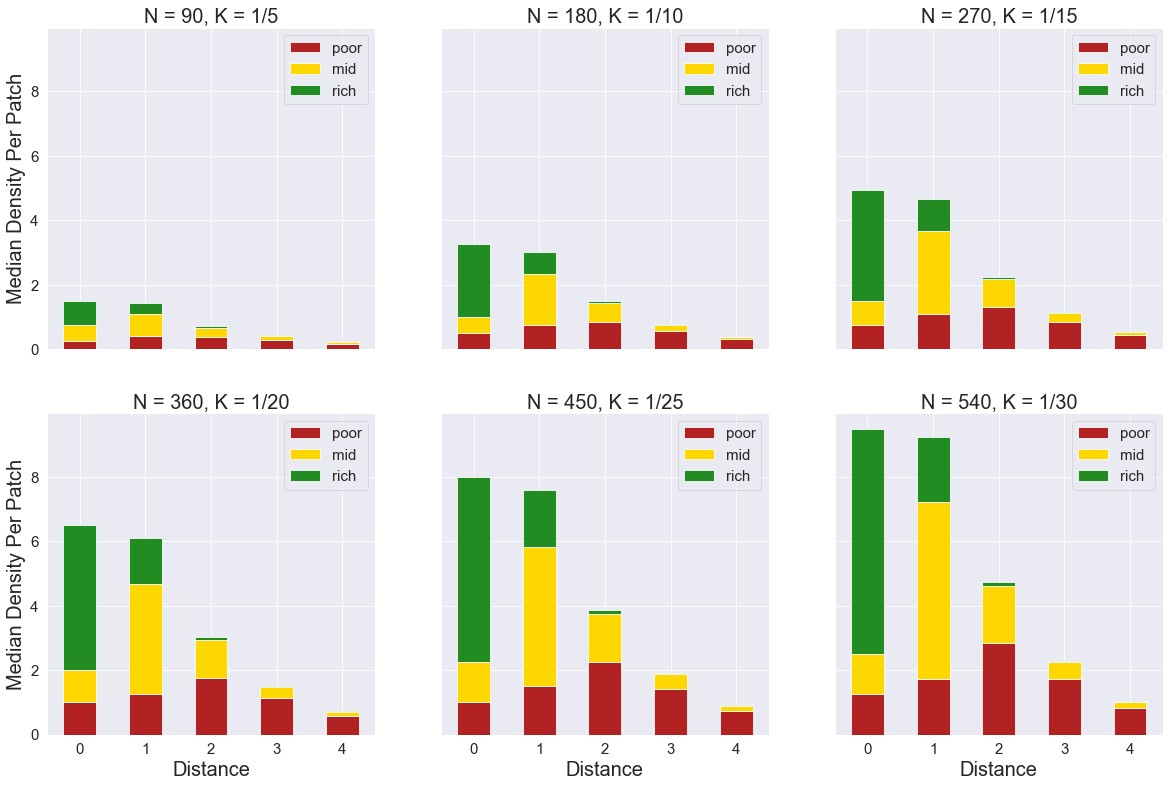

In [48]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, sharey=True, sharex=True, figsize=(20,13))

ratio = (5,3,1)
Nlst = [i for i in range(90, 540+1, 90)]
Klst = [i for i in range(5, 30+1, 5)]

for index in range(len(Nlst)):
    
    poorNlst = [[] for i in range(5)]
    midNlst = [[] for i in range(5)]
    richNlst = [[] for i in range(5)]

    barchartpd_covar = pd.DataFrame()
    
    for run in range(100):

        model_covar = ResidentialModel(
            width,height,
            N=Nlst[index],
            constant=Klst[index],
            job_dist = job_dist,
            land_dist = land_dist,
            people_types_ratios = ratio)
        for t in range(100):
            model_covar.step()

        #retrieve data and organize them into new dictionaries
        pctdistance_df = model_covar.computeNDistance.get_model_vars_dataframe()

        #for one simulation 
        for i in range(5):
            #for plotting N of income group over distance, calculate median of 100 steps at each distance
            poorNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistancePoor"]])/patchN[i], 2))
            midNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceMid"]])/patchN[i], 2))
            richNlst[i].append(round(np.median([entry[i] for entry in pctdistance_df["NDistanceRich"]])/patchN[i], 2))

    barchartpd_covar["poor"] = [np.median(i) for i in poorNlst]
    barchartpd_covar["mid"] = [np.median(i) for i in midNlst]
    barchartpd_covar["rich"] = [np.median(i) for i in richNlst]
    
    barchartpd_covar[['poor','mid','rich']].plot(kind='bar', stacked=True, 
                                           color=(poorColor, midColor, richColor), 
                                           rot=0, ax=axs[index//3, index%3]) \
        .set_title('N = %d, K = 1/%d' % (Nlst[index], Klst[index]))
    
for ax in axs.flat:
    ax.set(xlabel='Distance', ylabel='Median Density Per Patch')

plt.savefig('BarchartByCovariance.jpg')

### Generate Figure 1 and 2. Testing the expected value changes based on housing price equation.

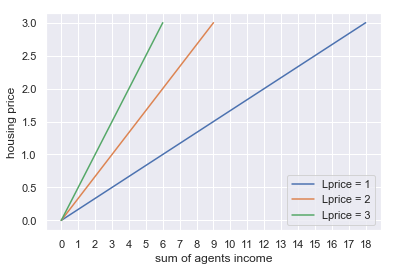

In [62]:
constant = 6
Lprice = 1
total_L1 = np.array(range(0, 19))
Hprice_L1 = Lprice * (total_L1/constant)
plt.plot(total_L1, Hprice_L1, label='Lprice = 1')
plt.xlabel('sum of agents income')
plt.ylabel('housing price')

Lprice2 = 2
total_L2 = np.array(range(0, 10))
Hprice_L2 = Lprice2 * (total_L2/constant)
plt.plot(total_L2, Hprice_L2, label='Lprice = 2')

Lprice3 = 3
total_L3 = np.array(range(0, 7))
Hprice_L3 = Lprice3 * (total_L3/constant) 
plt.plot(total_L3, Hprice_L3, label='Lprice = 3')

plt.xticks(np.arange(0, 19, 1))
plt.legend()

fig.set_size_inches(18.5, 10.5)
plt.savefig('HpricevsIncome.jpg', dpi=500)

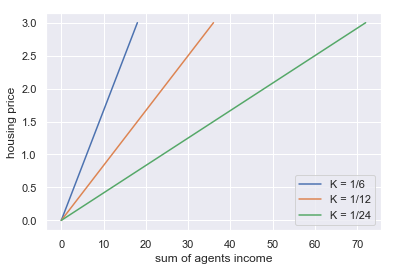

In [28]:
constant = 6
total_L1 = np.array(range(0, 19))
Hprice_L1 = total_L1/constant 
plt.plot(total_L1, Hprice_L1, label='K = 1/6')
plt.xlabel('sum of agents income')
plt.ylabel('housing price')

constant = 12 
total_L2 = np.array(range(0, 37))
Hprice_L2 = total_L2/constant 
plt.plot(total_L2, Hprice_L2, label='K = 1/12')
plt.xlabel('sum of agents income')
plt.ylabel('housing price')

constant = 24 
total_L3 = np.array(range(0, 73))
Hprice_L3 = total_L3/constant 
plt.plot(total_L3, Hprice_L3, label='K = 1/24')
plt.xlabel('sum of agents income')
plt.ylabel('housing price')

plt.legend()

fig.set_size_inches(18.5, 10.5)
plt.savefig('HpricevsIncomeDifferentK.jpg', dpi=500)